In [1]:
import torch
import numpy as np
import random
import os
def set_seed(seed):
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [2]:
! wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-06-25 04:48:30--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-06-25 04:48:30--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc77af120e69876d32593910a8b5.dl.dropboxusercontent.com/cd/0/inline/Bn1_HdhJ3VqvWkpcRzApPvQx8rUgYUwlDtiBCAiP8R8z05M869fB_HJ5LHnUj91KltKbki2XeeXBj8tVaX1bgENjvdLIOJYE45AR8D4uqCNfSE29rWHGzrhX_jGbudExZ_eS-UMa8h-lHt6MmZrErwqufHG1VFIotNmwXT0X-JK3tQ/file# [following]
--2022-06-25 04:48:30--  https://uc77af120e69876d32593910a8b5.dl.dropboxusercontent.com/cd/0/inline/Bn1_HdhJ3VqvWkpcRzApPvQx8rUgYUwlDtiBCAiP8R8z05M869fB_HJ5LHnUj9

In [3]:
!nvidia-smi


Sat Jun 25 04:48:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [5]:
images = []
lesions = []
from skimage.io import imread
import os
from torchsummary import summary
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
X.shape


(200, 256, 256, 3)

In [9]:
len(lesions)


200

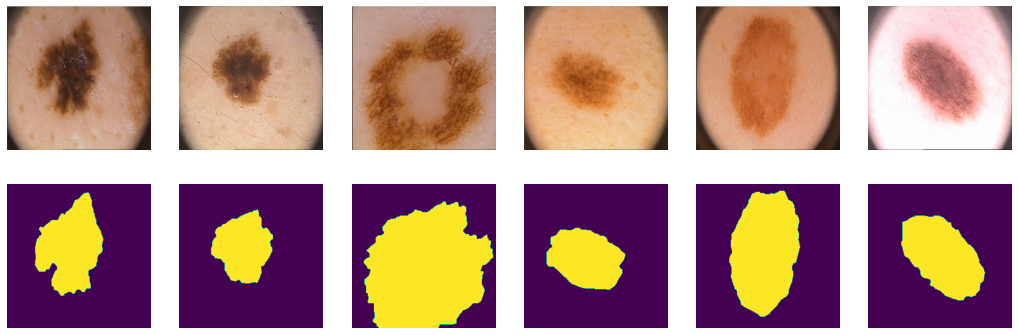

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [16]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [120, 160]) # разделим наши 200 картинок на трейн валидацию и тест

In [17]:
print(len(tr), len(val), len(ts))

120 40 40


In [18]:
from torch.utils.data import DataLoader
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True) #получается меняем с B x H x W x C
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True) #на B x C x H x W
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)